## Code Adapted from https://github.com/maziarraissi/PINNs

In [ ]:
pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=9caae0ea8551d6fb16ca5d87f39af06b7d288ca8d878d0208de059a077120514
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [ ]:
%tensorflow_version 1.x  

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from keras import backend as K

np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, q0, u0, v0, tb, X_f, layers_q, layers_u, layers_v, lb, ub ):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub

        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]

        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0
        self.q0 = q0

        # Initialize NNs
        self.layers_q = layers_q
        self.layers_u = layers_u
        self.layers_v = layers_v
        self.weights_q, self.biases_q = self.initialize_NN_q(layers_q)
        self.weights_u, self.biases_u = self.initialize_NN_u(layers_u)
        self.weights_v, self.biases_v = self.initialize_NN_v(layers_v)
        
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.q0_tf = tf.placeholder(tf.float32, shape=[None, self.q0.shape[1]])
      
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])

        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])

        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        self.q0_pred, _, _ = self.net_q(self.x0_tf, self.t0_tf)
        self.u0_pred, _ = self.net_u(self.x0_tf, self.t0_tf)
        self.v0_pred, _ = self.net_v(self.x0_tf, self.t0_tf)
        
        self.u_lb, self.u_x_lb_pred = self.net_u(self.x_lb_tf, self.t_lb_tf)
        self.v_lb, self.v_x_lb_pred = self.net_v(self.x_lb_tf, self.t_lb_tf)
        self.u_ub, self.u_x_ub_pred = self.net_u(self.x_ub_tf, self.t_ub_tf)
        self.v_ub, self.v_x_ub_pred = self.net_v(self.x_ub_tf, self.t_ub_tf)
        
        self.q_lb_pred, _, self.q_xx_lb_pred = self.net_q(self.x_lb_tf, self.t_lb_tf)
        self.q_ub_pred, _, self.q_xx_ub_pred = self.net_q(self.x_ub_tf, self.t_ub_tf)

        self.f_q_pred, self.f_u_pred, self.f_v_pred = self.net_f_quv(self.x_f_tf, self.t_f_tf)
        k=0.00006615
        le = 0.377
        bb1 = k*(self.u_lb+1)/(self.v_lb+1)*self.u_x_lb_pred
        bb2 = k*(self.u_ub+1)/(self.v_ub+1)*self.u_x_ub_pred
        bb3 = bb1-(le**2)*self.q_xx_lb_pred
        bb4 = bb2-(le**2)*self.q_xx_ub_pred
        C=1
        # Loss
        self.loss = tf.reduce_mean(C*tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(C*tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.q0_tf - self.q0_pred)) + \
                    tf.reduce_mean(tf.square(self.q_lb_pred - self.q_ub_pred)) + \
                    tf.reduce_mean(tf.square(bb3 - bb4)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) +\
                    tf.reduce_mean(tf.square(self.f_v_pred)) + tf.reduce_mean(tf.square(self.f_q_pred))
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        # self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=0.0001,amsgrad=True) #learning_rate=0.0001
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False, name='Adam')
        # self.optimizer_Adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', **kwargs)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)


    def initialize_NN_q(self, layers_q):        
        weights_q = []
        biases_q = []
        num_layers = len(layers_q) 
        for l in range(0,num_layers-1):
            W_q = self.xavier_init(size=[layers_q[l], layers_q[l+1]])
            b_q = tf.Variable(tf.zeros([1,layers_q[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_q.append(W_q)
            biases_q.append(b_q)        
        return weights_q, biases_q

  
    def initialize_NN_u(self, layers_u):        
        weights_u = []
        biases_u = []
        num_layers = len(layers_u) 
        for l in range(0,num_layers-1):
            W_u = self.xavier_init(size=[layers_u[l], layers_u[l+1]])
            b_u = tf.Variable(tf.zeros([1,layers_u[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_u.append(W_u)
            biases_u.append(b_u)        
        return weights_u, biases_u

    def initialize_NN_v(self, layers_v):        
        weights_v = []
        biases_v = []
        num_layers = len(layers_v) 
        for l in range(0,num_layers-1):
            W_v = self.xavier_init(size=[layers_v[l], layers_v[l+1]])
            b_v = tf.Variable(tf.zeros([1,layers_v[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights_v.append(W_v)
            biases_v.append(b_v)        
        return weights_v, biases_v    

        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net_q(self, X, weights_q, biases_q):
        num_layers = len(weights_q) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W_q = weights_q[l]
            b_q = biases_q[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_q), b_q))
        W_q = weights_q[-1]
        b_q = biases_q[-1]
        Y = tf.add(tf.matmul(H, W_q), b_q)
        return Y
    
    def net_q(self, x, t):
        X = tf.concat([x,t],1)
        
        q = self.neural_net_q(X, self.weights_q, self.biases_q)
        
        q_x = tf.gradients(q, x)[0]

        q_xx = tf.gradients(q_x, x)[0]
        
        return q, q_x, q_xx

    def neural_net_u(self, X, weights_u, biases_u):
        num_layers = len(weights_u) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W_u = weights_u[l]
            b_u = biases_u[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_u), b_u))
        W_u = weights_u[-1]
        b_u = biases_u[-1]
        Y = tf.add(tf.matmul(H, W_u), b_u)
        return Y
    
    def net_u(self, x, t):
        X = tf.concat([x,t],1)
        
        u = self.neural_net_u(X, self.weights_u, self.biases_u)
        
        u_x = tf.gradients(u, x)[0]
        
        return u, u_x


    def neural_net_v(self, X, weights_v, biases_v):
        num_layers = len(weights_v) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W_v = weights_v[l]
            b_v = biases_v[l]
            H = tf.tanh(tf.add(tf.matmul(H, W_v), b_v))
        W_v = weights_v[-1]
        b_v = biases_v[-1]
        Y = tf.add(tf.matmul(H, W_v), b_v)
        return Y

    def net_v(self, x, t):
        X = tf.concat([x,t],1)
        
        v = self.neural_net_v(X, self.weights_v, self.biases_v)
        
        v_x = tf.gradients(v, x)[0]
        
        return v, v_x


    def net_f_quv(self, x, t):
        
        q,q_x,q_xx = self.net_q(x,t)

        u,u_x = self.net_u(x,t)

        v,v_x = self.net_v(x,t)
        
        
        q_t = tf.gradients(q, t)[0]
        q_tx = tf.gradients(q_t, x)[0]
        q_xxx = tf.gradients(q_xx, x)[0]
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        

        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]

        ce=2.1E-5*(u+1)
        cl=2.5E-3
        G=0.0000182
        k=0.00006615
        beta = 0.333333333333333
        k_ce = beta*k/ce
        tp= 0.142857142857143
        delta= 0.153
        R=0.93
        J=0.000446666666666667
        pow = x/delta+2.77*((t-2*tp)/(tp))**2
        sp = (0.94)*((1-R)/(tp*delta))*J
        S= (sp/ce)*tf.math.exp(-pow)
        tau1 = 0.039
        l_e = 0.377
        new_cons = beta*l_e**2
        new_bt = beta*tau1
        G_new = G/ce
        G_new1 = G/cl
        tau = 0.039
        tau_inv = 1.0/tau
        k_tau = k/tau
        le_tau = l_e**2/tau

        f_q = q_t + tau_inv*q +  (k_tau)*u_x  - (le_tau)**2*q_xx 
        f_u = u_t - (k_ce*((u+1)/(v+1))*u_xx + (k_ce)*(u_x*(v+1)-v_x*(u+1))/((v+1)**2)*(u_x)) + new_cons*q_xxx - new_bt*q_tx  + G_new*(u-v) - S
        f_v = v_t - G_new1*(u-v)

        return f_q, f_u, f_v


    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.q0_tf: self.q0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        q_star = self.sess.run(self.q0_pred, tf_dict)
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_q_star = self.sess.run(self.f_q_pred, tf_dict)
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)

                       
        return q_star, u_star, v_star, f_q_star, f_u_star, f_v_star
    
if __name__ == "__main__": 
     
    noise = 0.0        
    
    # Doman bounds
    lb = np.array([0.0, 0.0])
    ub = np.array([1.0, 1.0])

    
    N0 = 50
    N_b = 50
    N_f = 10000
    
    layers_q = [2, 100, 100, 100, 100, 100, 100, 100, 1]
    layers_u = [2, 100, 100, 100, 100, 100, 100, 100, 1]
    layers_v = [2, 100, 100, 100, 100, 100, 100, 100,  1]

    t = np.linspace(0.0,1.0,500).flatten()[:,None]
    x = np.linspace(0.0,1.0,900).flatten()[:,None]
    ui = np.linspace(0.0,0.0,900).flatten()[:,None] # based on size of X_star
    vi = ui
    qi = ui
    Exact_q = qi
    Exact_u = ui
    Exact_v = vi
    
    X, T = np.meshgrid(x,t)
    

    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    q_star = Exact_q.T.flatten()[:,None]
    u_star = Exact_u.T.flatten()[:,None]
    v_star = Exact_v.T.flatten()[:,None]
    
    

    ###########################
    
    idx_x = np.random.choice(x.shape[0], N0, replace=False)
    x0 = x[idx_x,:]
    q0 = Exact_q[idx_x,0:1]
    u0 = Exact_u[idx_x,0:1]
    v0 = Exact_v[idx_x,0:1]
    
    
    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t,:]
    
    X_f = lb + (ub-lb)*lhs(2, N_f)
    
    
            
    model = PhysicsInformedNN(x0, q0, u0, v0, tb, X_f, layers_q, layers_u, layers_v, lb, ub)
             
    start_time = time.time()                
    model.train(50000)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
        
    q_pred, u_pred, v_pred, f_q_pred, f_u_pred, f_v_pred = model.predict(X_star)
    
   
    Q_pred = griddata(X_star, q_pred.flatten(), (X, T), method='cubic')
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
    
    
    FQ_prec = griddata(X_star, f_q_pred.flatten(), (X, T), method='cubic')
    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
    FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')     
    
    

    

Streaming output truncated to the last 5000 lines.
It: 270, Loss: 5.350e+00, Time: 0.80
It: 280, Loss: 5.314e+00, Time: 0.76
It: 290, Loss: 5.282e+00, Time: 0.78
It: 300, Loss: 5.250e+00, Time: 0.77
It: 310, Loss: 5.219e+00, Time: 0.76
It: 320, Loss: 5.187e+00, Time: 0.76
It: 330, Loss: 5.155e+00, Time: 0.79
It: 340, Loss: 5.121e+00, Time: 0.81
It: 350, Loss: 5.087e+00, Time: 0.79
It: 360, Loss: 5.051e+00, Time: 0.78
It: 370, Loss: 5.014e+00, Time: 0.77
It: 380, Loss: 4.975e+00, Time: 0.77
It: 390, Loss: 5.427e+00, Time: 0.77
It: 400, Loss: 5.035e+00, Time: 0.77
It: 410, Loss: 4.947e+00, Time: 0.78
It: 420, Loss: 4.887e+00, Time: 0.78
It: 430, Loss: 4.819e+00, Time: 0.79
It: 440, Loss: 4.766e+00, Time: 0.79
It: 450, Loss: 4.710e+00, Time: 0.78
It: 460, Loss: 4.654e+00, Time: 0.79
It: 470, Loss: 4.597e+00, Time: 0.79
It: 480, Loss: 4.537e+00, Time: 0.79
It: 490, Loss: 4.475e+00, Time: 0.80
It: 500, Loss: 4.411e+00, Time: 0.79
It: 510, Loss: 4.343e+00, Time: 0.79
It: 520, Loss: 4.274e+00

In [ ]:
U_val3 = U_pred*300+300
V_val3 = V_pred*300+300


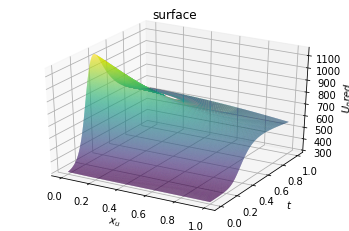

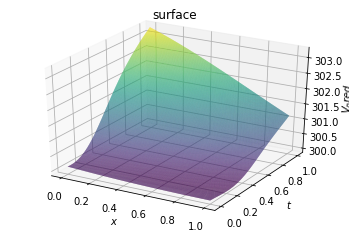

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, V_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$V_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')



In [ ]:
np.max(U_val3)

1149.067497253418

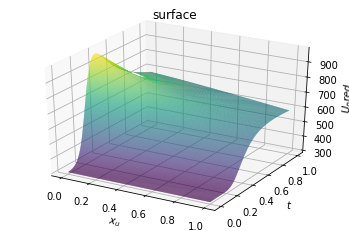

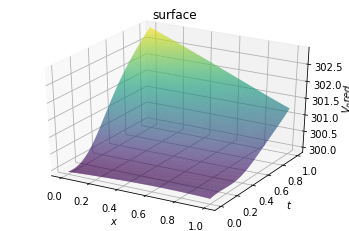

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, V_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$V_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')



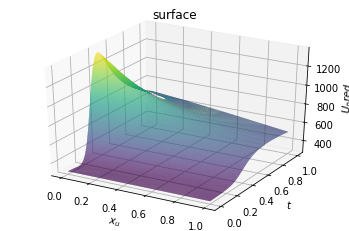

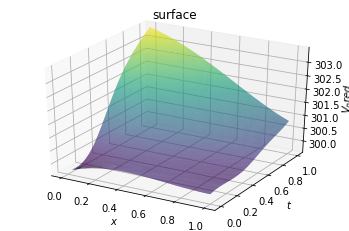

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, V_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$V_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')



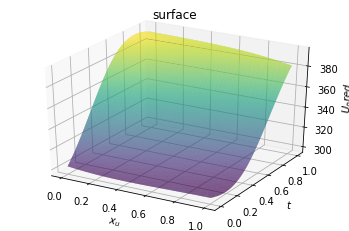

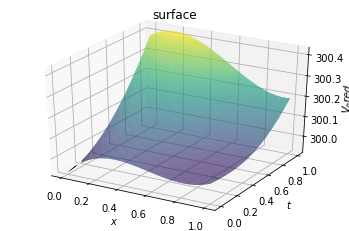

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, V_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$V_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')



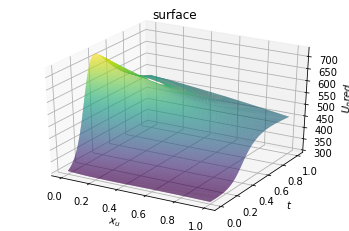

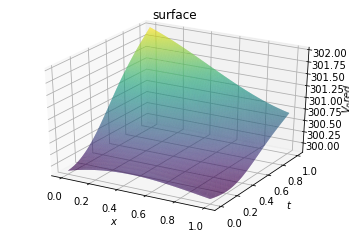

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, V_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$V_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')



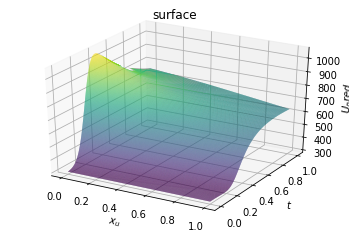

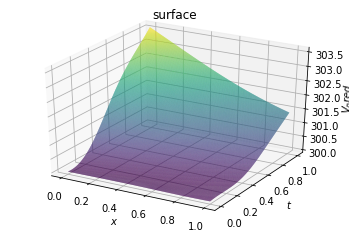

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, V_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$V_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')



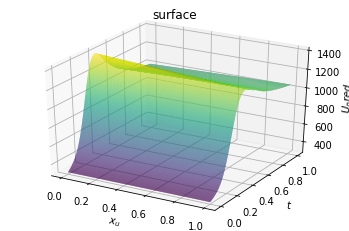

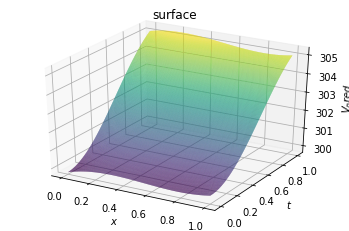

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, V_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$V_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')



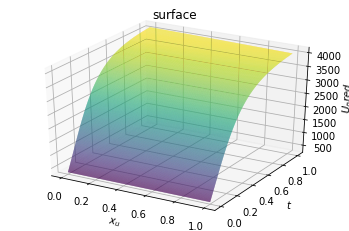

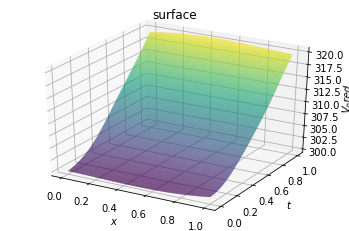

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, V_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$V_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')



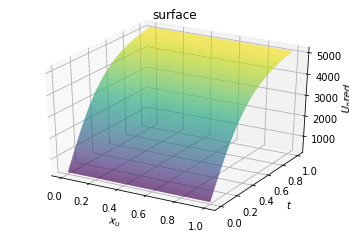

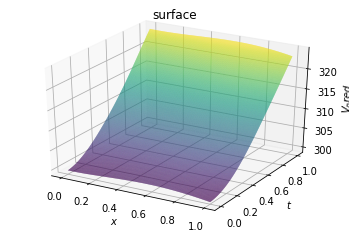

In [ ]:
    fig = plt.figure()
    X, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, U_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_u$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$U_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')

    fig = plt.figure()
    X2, T = np.meshgrid(x, t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, T, V_val3, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$V_pred$')
    ax.set_title('surface');
    #plt.savefig('surf.pdf')



In [ ]:
np.savetxt('elec_new01.out', U_val3, delimiter=',')
np.savetxt('latt_new01.out', V_val3, delimiter=',')
from google.colab import files
files.download('elec_new01.out')
files.download('latt_new01.out')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.savetxt('elec_norm.out', U_pred, delimiter=',')
np.savetxt('latt_norm.out', V_pred, delimiter=',')
np.savetxt('q_norm.out', Q_pred, delimiter=',')
from google.colab import files
files.download('elec_norm.out')
files.download('latt_norm.out')
files.download('q_norm.out')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>